## RedHat Kaggle

https://www.kaggle.com/c/predicting-red-hat-business-value

##### Load libraries

In [1]:
import pandas as pd
import scipy as sp
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import multiprocessing
from collections import Counter, defaultdict
import hashlib
import re
from sklearn.learning_curve import validation_curve
import matplotlib.pyplot as plt
%matplotlib inline

CPUS = multiprocessing.cpu_count()

In [2]:
CPUS

16

##### Custom Functions

In [3]:
def format_col(x, p):
    if type(x)==str:
        return p+'_'+x.replace(' ','_')
    else:
        return p+'_'+str(x)

def update_cols(df,c=1):
    # fix date columns
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    del df['date']
    
    # get list of columns
    cols = list(df.columns)
    
    # include column name with value
    for p in cols[c:]:
        df.loc[:,p] = df.loc[:,p].apply(lambda x: format_col(x, p) )
    
    return df

In [4]:
def test_scores(y_test, predictions, pr=True):
    ll = log_loss(y_test, predictions)
    a = accuracy_score(y_test, np.argmax(predictions,axis=1))
    auc = roc_auc_score(np.c_[y_test==0, y_test==1], predictions)
    r = {'c':c,'logloss':ll,'accuracy':a,'AUC':auc}
    pstr = '''C:{c} Log-Loss:{logloss:.7f} Accuracy:{accuracy:.7f} AUC:{AUC:.7f}'''
    if pr: print pstr.format(**r)
    return r

In [5]:
def create_sparse_ohe_data(df, ohe_dict):
    rows = []
    cols = []
    data = []
    for i in xrange(df.shape[0]):
        s = map(lambda x: ohe_dict.get(x,-1), df.iloc[i])
        while True:
            if -1 in s:
                indval = s.index(-1)
                del s[indval]
            else:
                break
        rows += [i]*len(s)
        cols += s
        data += [1]*len(s)
    return csr_matrix((np.array(data),
                (np.array(rows),
                 np.array(cols))),
               shape=(df.shape[0],len(ohe_dict)))

In [6]:
def create_sparse_hash_data(df, num_buckets):
    rows = []
    cols = []
    data = []
    for i in xrange(df.shape[0]):
        mapping = {}
        for f in df.iloc[i]:
            mapping[f] = int(int(hashlib.md5(f).hexdigest(), 16) % num_buckets)
        s = defaultdict(float)
        for bucket in mapping.values():
            s[bucket] += 1.0
        rows += [i]*len(s)
        cols += s.keys()
        data += s.values()
    return csr_matrix((np.array(data),
                (np.array(rows),
                 np.array(cols))),
               shape=(df.shape[0],num_buckets))

In [7]:
def create_missing_val_lookup(df):
    mode_str = lambda x: Counter(list(x)).most_common(1)[0][0]
    char_cols = [ c for c in list(df.columns) if re.search('char_',c)]

    def find_char_modes(df, char_cols):
        for char_col in char_cols:
            nonnulls = df[char_col].apply(lambda x: str(x).lower()!='nan')
            char_r = df.loc[nonnulls, char_col].groupby(level=0).apply(mode_str)
            yield char_r

    def find_mode_overall(df, char_cols):
        for char_col in char_cols:
            nonnulls = df[char_col].apply(lambda x: str(x).lower()!='nan')
            freq_val = df.loc[nonnulls, char_col].reset_index().apply(mode_str)[char_col]
            yield freq_val

    # find most common result for each column-person
    char_col_results = find_char_modes(df, char_cols)

    # find most common result overall for each column
    freq_results = find_mode_overall(df, char_cols)

    # create lookup table for missing values
    missing_val_lookup = pd.DataFrame(pd.concat(char_col_results, axis=1), columns=char_cols)
    freq_lookup = pd.DataFrame(freq_results, index=char_cols, columns=['most_freq'])
    freq_lookup_dict = freq_lookup.to_dict()['most_freq']
    missing_val_lookup = missing_val_lookup.fillna(freq_lookup_dict, axis=0)
    
    return missing_val_lookup, freq_lookup_dict

In [8]:
def lr_validation_curve(X, y, 
                        param_range= np.logspace(-3, 3, 3), 
                        max_iter=100, 
                        tol=1e-5, 
                        cv=5, 
                        n_jobs=CPUS):
    lr_model = LogisticRegression(max_iter=max_iter, tol=tol)
    train_scores, test_scores = validation_curve(lr_model, X, y, 
                                param_name="C", param_range=param_range,
                                cv=cv, scoring="accuracy", n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with Logistic Regression")
    plt.xlabel("C")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

##### Load data

In [9]:
DIR = '/'
FTRAIN = 'Data/act_train.csv.gz'
FTEST = 'Data/act_test.csv.gz'
FPEOPLE = 'Data/people.csv.gz'
FSAMPLE = 'Data/sample_submission.csv.gz'

In [10]:
train_raw = pd.read_csv(DIR+FTRAIN)
test_raw = pd.read_csv(DIR+FTEST)
people = pd.read_csv(DIR+FPEOPLE)

In [11]:
Y = train_raw['outcome']
del train_raw['outcome']

##### Baseline model

In [12]:
p = Y.value_counts()*1.0 / train_raw.shape[0]

In [13]:
N = train_raw.shape[0]
predictions = np.zeros((N,2))
for i in xrange(N):
    predictions[i,:] = p

In [14]:
accuracy_score(Y, np.argmax(predictions,axis=1))

0.55604560342712916

In [15]:
log_loss(Y, predictions)

0.68685173924161147

In [16]:
roc_auc_score(np.c_[Y==0,Y==1], predictions)

0.5

##### Handle null values

In [17]:
train_raw.index = train_raw['people_id']
test_raw.index = test_raw['people_id']
people.index = people['people_id']
del train_raw['people_id']
del test_raw['people_id']
del people['people_id']

people_lookup, freq_lookup = create_missing_val_lookup(train_raw)
train_raw = train_raw.fillna( people_lookup, axis=0)

test_raw = test_raw.fillna( people_lookup, axis=0 )
test_raw = test_raw.fillna( freq_lookup, axis=0 )

##### Feature updates for sparse matrix

In [18]:
percentile_ref = people['char_38'].ravel()
compare_percentile = lambda x: round(sp.stats.percentileofscore(percentile_ref, x, kind='weak'),-1)
people['char_38'] = people['char_38'].apply(compare_percentile)

In [19]:
people = update_cols(people, 0)
train_raw = update_cols(train_raw, 1)
test_raw = update_cols(test_raw, 1)

##### Transform data to sparse OHE matrix

In [20]:
train_full = pd.merge(train_raw, people, left_index=True, right_index=True)
test_full = pd.merge(test_raw, people, left_index=True, right_index=True)
train_full.index = train_full['activity_id']
test_full.index = test_full['activity_id']
del train_full['activity_id']
del test_full['activity_id']

In [21]:
sum(train_full.memory_usage())*1.0/1024**3

0.96589452773332596

In [22]:
sum(test_full.memory_usage())*1.0/1024**3

0.21921495348215103

##### Create OHE dictionary 

In [23]:
all_values = np.unique(train_full.as_matrix().reshape(1,-1).ravel())
ohe_dict= { k: v for k,v in zip(all_values, xrange(all_values.shape[0])) }

In [24]:
len(ohe_dict)

36779

##### Create sparse matrices for test and training datasets

In [25]:
X = create_sparse_ohe_data(train_full, ohe_dict)

In [26]:
X_test = create_sparse_ohe_data(test_full, ohe_dict)

In [27]:
IDs = np.array(test_full.index)

In [28]:
X.shape

(2197291, 36779)

##### Clear unused memory

In [29]:
del train_full 
del train_raw
del test_full
del test_raw
del ohe_dict
del all_values
del people 

##### Split train and validation

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  Y, 
                                                  test_size=0.20, 
                                                  random_state=2)

### Logistic Regression

#### Check model parameter tuning
Using a sample of data to limit runtime.  
Assumes that sampled validation curve will match full dataset.

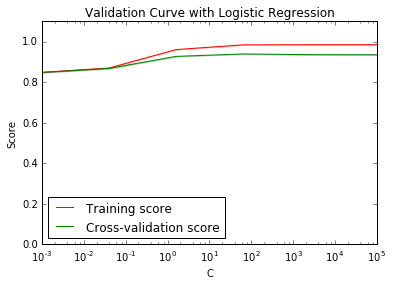

In [33]:
sample = np.random.choice(xrange(X.shape[0]),size=100000)
lr_validation_curve(X[sample,:], 
                    Y.iloc[sample], 
                    param_range= np.logspace(-3, 5, 6), 
                    n_jobs=6)

#### Run full model

In [ ]:
c = 1e2
lr = LogisticRegression(C=c, max_iter=500, tol=1e-5, n_jobs=CPUS)
lr.fit(X, Y)
predictions = lr.predict_proba(X_test)

#### Submission

In [ ]:
submission = pd.DataFrame(np.vstack((IDs, 
                                     predictions[:,1])).T,
                          columns=['activity_id','outcome'])
submission.to_csv('submission.csv', index=False)

!gzip submission.csv
!s3put -bbrandonshurick -p/home/ubuntu/ -gpublic-read submission.csv.gz 

### XGBoost

In [27]:
import xgboost as xgb

In [28]:
def test_scores_xgb(y_val, predictions):
    pfull = np.c_[1-predictions,predictions]
    ll = log_loss(y_val, pfull)
    a = accuracy_score(y_val, np.argmax(pfull ,axis=1))
    auc = roc_auc_score(np.c_[y_val==0, y_val==1], pfull)
    r = {'logloss':ll,'accuracy':a,'AUC':auc}
    return r

In [29]:
dtrain = xgb.DMatrix( X_train, label=y_train.as_matrix() )
dval = xgb.DMatrix( X_val, label=y_val.as_matrix() )
dtest = xgb.DMatrix( X_test )

#### Train final model

In [ ]:
d = 500
e = 0.01
param = {'max_depth':d, 
         'eta':e, 
         'subsample':0.5, 
         'colsample_bytree':0.75,
         'colsample_bylevel':0.75,
         'silent':1, 
         'objective':'binary:logistic' }
param['eval_metric'] = 'auc'
param['nthread'] = CPUS
evallist  = [(dval,'eval'), (dtrain,'train')]
xgb_model = xgb.train(param.items(), dtrain, 501, evallist, verbose_eval=50)

[0]	eval-auc:0.986746	train-auc:0.989671
[50]	eval-auc:0.997443	train-auc:0.998835


In [ ]:
predictions = xgb_model.predict( dval )
test_scores_xgb(y_val, predictions)

#### Submission

In [ ]:
predictions = xgb_model.predict( dtest )

In [ ]:
submission = pd.DataFrame(np.vstack((IDs, 
                                     predictions)).T,
                          columns=['activity_id','outcome'])
submission.to_csv('submission.csv', index=False)

In [ ]:
!gzip submission.csv !s3put -bbrandonshurick -p/home/ubuntu/ -gpublic-read submission.csv.gz